In [1]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import random_split

import dgl
from dgl import function as fn
from dgl import DGLGraph
from dgl.data import citation_graph as citegrh

import networkx as nx
import matplotlib.pyplot as plt
import random as rand
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [2]:


#set gpu if available
if th.cuda.is_available():
    print("GPU is available")
    #device = th.device("cuda")
    device = th.device("cuda")
else:
    print("GPU not available, CPU used")
    device = th.device("cpu")

GPU is available


In [3]:
#operation for neigbors
class NodeApplyModule(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(NodeApplyModule, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.activation = activation

    def forward(self, node):
        h = self.linear(node.data['h'])
        if self.activation is not None:
            h = self.activation(h)
        return {'h' : h}
    
#gcn layer in network
class GCN(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(GCN, self).__init__()
        self.apply_mod = NodeApplyModule(in_feats, out_feats, activation)

    def forward(self, g, feature):
        g.ndata['h'] = feature
        g.pull(g.nodes())
        g.apply_nodes(self.apply_mod)
        
        return g.ndata.pop('h')
    
#network
class LIGN(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(LIGN, self).__init__()
        self.gcn1 = GCN(in_feats, 100, F.relu)
        self.gcn2 = GCN(100, 30, F.relu)
        self.gcn3 = GCN(30, out_feats, th.tanh)

    def forward(self, g, features):
        x = self.gcn1(g, features)
        x = self.gcn2(g, x)
        
        return self.gcn3(g, x)


In [4]:
#loss function

def similarity_matrix(x): #pairwise distance
    x_norm = (x**2).sum(1).view(-1, 1)
    y = x
    y_norm = x_norm.view(1, -1)

    dist = x_norm + y_norm - 2.0 * th.mm(x, th.transpose(y, 0, 1))
    return dist

def same_label(y):
    s = y.size(0)
    y_expand = y.unsqueeze(0).expand(s, s)
    Y = y_expand.eq(y_expand.t())
    return Y

def my_loss(output, labels):
    """
    if nodes with the same label: x^2
    if nodes with different label: 1/(10*x^2)
    """
    sim = similarity_matrix(output)
    temp = same_label(labels)
    same_l = (temp * sim) / (output.size(0)**2)
    same_l_inv = ((temp*(-1) + 1) * sim) / (output.size(0)**2)
    
    #loss = ((th.sum(same_l**2)) + (1/(10*th.sum(same_l_inv**2))))
    loss = th.sum(same_l**2) + output.size(0)*2**(-1/2*th.sum(same_l_inv**2))
    #loss = th.sum(same_l**2) + th.sum(same_l_inv**2)
    
    return loss

def has_1_rand_label(nodes): return (nodes.data['t_labels'] == possible_lab[0]).squeeze(0)

def filter_knn_label(nodes): return (nodes.data['t_labels'] == curr_used_lab).squeeze(0)



In [5]:
#load dataset
data = citegrh.load_cora()
ds_features = th.FloatTensor(data.features).to(device) #convert to pytorch data type and add to cpu/gpu
ds_labels = th.LongTensor(data.labels).to(device)
ds_g = data.graph

# add self loop for the sum of festures
ds_g.remove_edges_from(nx.selfloop_edges(ds_g))
ds_g = DGLGraph(ds_g)
ds_g.add_edges(ds_g.nodes(), ds_g.nodes())
ds_g.ndata['features'] = ds_features
ds_g.ndata['t_labels'] = ds_labels #used to filter and train the first two labels, not needed for prediction

# to coordinate sending of features over the graph network
m_func = fn.copy_src(src='h', out='m')
m_reduce_func = fn.sum(msg='m', out='h')

In [6]:
########### Create Model ############

#constant parameters
DIST_VEC_SIZE = 2
NUMBER_OF_LABELS = th.unique(ds_g.ndata["t_labels"]).size(0)
k_NEIGHBOR = 1

model = LIGN(ds_features.size()[1], DIST_VEC_SIZE).to(device)
knn = KNeighborsClassifier(n_neighbors=k_NEIGHBOR)
opt = th.optim.Adam(model.parameters(), lr=1e-3)# only run once

In [7]:
#training

train_g = ds_g.subgraph(ds_g.nodes()[:int(len(ds_g) * 1)])#800 percent of all the nodes
test_g = ds_g.subgraph(ds_g.nodes()[int(len(ds_g) * .80):]) #20 percent labeled nodes for knn
train_g.copy_from_parent()
test_g.copy_from_parent()

#both dataset should include all labels
while th.unique(train_g.ndata["t_labels"]).size(0) != th.unique(test_g.ndata["t_labels"]).size(0):
    c=th.randperm(len(ds_g.nodes())) #shuffle
    ds_g.nodes =ds_g.nodes()[c]
    
    train_g = ds_g.subgraph(ds_g.nodes()[:int(len(ds_g) * 1)])#100 percent of all the nodes
    test_g = ds_g.subgraph(ds_g.nodes()[int(len(ds_g) * .80):]) #20 percent labeled nodes for knn
    train_g.copy_from_parent()
    test_g.copy_from_parent()


possible_lab = list(range(NUMBER_OF_LABELS))
rand.shuffle(possible_lab) #set random order for how labels are added
used_lab = []
curr_used_lab = 0

EPOCH = 50
EPOCH_SIZE = 0
INIT_NUM_LAB = 2 #must be at least 1

model.train()

#############train with 2 labels of 7 labels (uses true label from the dataset), assign vector to each node,
            #knn (1 labeled node for each label), test
selected_nodes = train_g.filter_nodes(has_1_rand_label) #add two unseen labels
used_lab.append(possible_lab.pop(0))
for i in range(INIT_NUM_LAB - 1):
    selected_nodes = th.cat((train_g.filter_nodes(has_1_rand_label), selected_nodes), -1)
    used_lab.append(possible_lab.pop(0))

c=th.randperm(len(selected_nodes)) #shuffle
selected_nodes=selected_nodes[c]

EPOCH_SIZE = int(len(selected_nodes)*.20)

#train
for epoch in range(EPOCH):
    print("> " + str(epoch))
    c=th.randperm(len(selected_nodes)) #shuffle
    selected_nodes=selected_nodes[c]
    
    epoch_nodes = selected_nodes[:EPOCH_SIZE] #selected 20% of random nodes to train with at each epoch
    
    error = []
    for count in range(int(len(epoch_nodes)*.1), len(epoch_nodes)):
        sub_graph = train_g.subgraph(epoch_nodes[:count])
        sub_graph.copy_from_parent()
        sub_graph.register_message_func(m_func)
        sub_graph.register_reduce_func(m_reduce_func)
        
        feats = sub_graph.ndata['features']
        labs = sub_graph.ndata['t_labels'] #true label
        
        out = model(sub_graph, feats)
        loss = my_loss(out, labs)
        error.append(loss.item())
        
        opt.zero_grad()
        loss.backward()
        opt.step()
    #print(np.mean(error))
    
#knn and assign vector
sub_tra_graph = train_g.subgraph(selected_nodes)
sub_tra_graph.copy_from_parent()
sub_tra_graph.register_message_func(m_func)
sub_tra_graph.register_reduce_func(m_reduce_func)

##test graph knn
out_nodes = th.LongTensor([])
for n in used_lab:
    curr_used_lab = n
    out_nodes = th.cat((test_g.filter_nodes(filter_knn_label), out_nodes), -1)

c=th.randperm(len(out_nodes)) #shuffle
out_nodes=out_nodes[c]

sub_tes_graph = test_g.subgraph(out_nodes)
sub_tes_graph.copy_from_parent()
sub_tes_graph.register_message_func(m_func)
sub_tes_graph.register_reduce_func(m_reduce_func)

knn.fit(model(sub_tes_graph, sub_tes_graph.ndata['features']).cpu().detach().numpy(), sub_tes_graph.ndata['t_labels'].cpu().detach().numpy())
sub_tra_graph.ndata['p_labels'] = th.LongTensor(knn.predict(model(sub_tra_graph, sub_tra_graph.ndata['features']).cpu().detach().numpy())).to(device)

print((sub_tra_graph.ndata['t_labels']).cpu().detach().numpy())
print((sub_tra_graph.ndata['p_labels']).detach().cpu().numpy())

#test
print(f"> Initial training with {INIT_NUM_LAB} labels (distinction efficiency): {metrics.accuracy_score((sub_tra_graph.ndata['t_labels']).cpu().detach().numpy(), (sub_tra_graph.ndata['p_labels']).detach().cpu().numpy())}")



> 0
> 1
> 2
> 3
> 4
> 5
> 6
> 7
> 8
> 9
> 10
> 11
> 12
> 13
> 14
> 15
> 16
> 17
> 18
> 19
> 20
> 21
> 22
> 23
> 24
> 25
> 26
> 27
> 28
> 29
> 30
> 31
> 32
> 33
> 34
> 35
> 36
> 37
> 38
> 39
> 40
> 41
> 42
> 43
> 44
> 45
> 46
> 47
> 48
> 49
[0 4 0 0 4 4 4 4 4 0 0 4 0 4 0 0 0 4 4 4 0 0 0 4 0 0 0 4 0 0 0 0 4 0 0 0 0
 4 0 0 0 4 0 0 0 0 4 0 0 0 4 0 0 4 4 0 0 0 4 4 4 0 4 4 0 4 4 0 0 4 0 4 4 4
 0 0 0 0 4 4 0 0 0 0 0 0 4 4 0 4 0 0 0 0 0 4 0 0 0 4 4 4 0 0 0 4 0 0 4 0 4
 0 4 0 4 4 4 4 0 0 0 0 0 4 0 4 0 0 0 0 4 4 0 4 0 0 4 4 0 4 4 4 0 0 4 4 0 0
 0 4 4 0 0 4 4 4 0 4 4 4 0 4 4 0 0 4 0 0 4 0 4 0 0 4 0 0 0 4 0 0 0 0 4 4 4
 0 0 4 4 0 0 4 0 4 0 0 0 0 0 0 0 0 0 0 4 0 4 0 0 0 0 4 0 4 0 0 0 0 4 0 0 0
 0 0 4 4 0 4 4 0 0 0 0 0 4 4 4 0 0 4 0 0 4 0 0 0 4 0 4 0 0 0 0 0 4 0 4 0 4
 0 0 0 4 4 4 0 0 0 4 4 4 0 4 4 4 0 4 0 4 4 0 4 4 0 4 4 0 0 0 4 0 0 4 0 4 4
 0 4 4 4 0 0 4 4 4 4 0 0 0 0 0 0 0 0 4 0 0 0 0 4 4 0 0 0 0 0 4 0 4 0 0 0 0
 4 4 0 0 4 4 0 0 4 0 4 4 0 0 0 4 0 4 0 4 0 4 0 0 4 0 0 4 0 4 0 4 0 0 0 0 4
 0 0 0 4 4

In [8]:
  
#training 
#######################add label, assign vector to each node, knn, test and train (with predicted labels by knn)

while len(possible_lab) > 0: #do it for every unseen label
    selected_nodes = th.cat((train_g.filter_nodes(has_1_rand_label), selected_nodes), -1) #add unseen new label (change 1 to 2 to add to labels at once)
    used_lab.append(possible_lab.pop(0))
    
    c=th.randperm(len(selected_nodes)) #shuffle
    selected_nodes=selected_nodes[c]
    
    #assign vector
    
    #########
    sub_tra_graph = train_g.subgraph(selected_nodes)
    sub_tra_graph.copy_from_parent()
    sub_tra_graph.register_message_func(m_func)
    sub_tra_graph.register_reduce_func(m_reduce_func)

    ##test graph knn
    out_nodes = th.LongTensor([])
    for n in used_lab:
        curr_used_lab = n
        out_nodes = th.cat((test_g.filter_nodes(filter_knn_label), out_nodes), -1)

    c=th.randperm(len(out_nodes)) #shuffle
    out_nodes=out_nodes[c]

    sub_tes_graph = test_g.subgraph(out_nodes)
    sub_tes_graph.copy_from_parent()
    sub_tes_graph.register_message_func(m_func)
    sub_tes_graph.register_reduce_func(m_reduce_func)

    knn.fit(model(sub_tes_graph, sub_tes_graph.ndata['features']).cpu().detach().numpy(), sub_tes_graph.ndata['t_labels'].cpu().detach().numpy())
    sub_tra_graph.ndata['p_labels'] = th.LongTensor(knn.predict(model(sub_tra_graph, sub_tra_graph.ndata['features']).cpu().detach().numpy())).to(device)
    train_g.nodes[sub_tra_graph.parent_nid].data['p_labels'] = sub_tra_graph.ndata['p_labels']
    
    #test
    print(f"After new label added and before retraining (total: {len(used_lab)}), accuracy of all nodes: {metrics.accuracy_score((sub_tra_graph.ndata['t_labels']).cpu().detach().numpy(), (sub_tra_graph.ndata['p_labels']).detach().cpu().numpy())}")
    #########
    
    for epoch in range(EPOCH):
        print("> " + str(epoch))
        c=th.randperm(len(selected_nodes)) #shuffle
        selected_nodes=selected_nodes[c]
        epoch_nodes = selected_nodes[:EPOCH_SIZE] #select 20% of random nodes to train with at each epoch

        error = []
        for count in range(len(epoch_nodes)):
            sub_graph = train_g.subgraph(epoch_nodes[:count])
            sub_graph.copy_from_parent()
            sub_graph.register_message_func(m_func)
            sub_graph.register_reduce_func(m_reduce_func)

            feats = sub_graph.ndata['features']
            
            labs = sub_graph.ndata['p_labels'] #change to predicted label by knn (if label not given) *********

            out = model(sub_graph, feats)
            loss = my_loss(out, labs)
            error.append(loss.item())

            opt.zero_grad()
            loss.backward()
            opt.step()

After new label added and before retraining (total: 3), accuracy of all nodes: 0.5889145496535797
> 0
> 1
> 2
> 3
> 4
> 5
> 6
> 7
> 8
> 9
> 10
> 11
> 12
> 13
> 14
> 15
> 16
> 17
> 18
> 19
> 20
> 21
> 22
> 23
> 24
> 25
> 26
> 27
> 28
> 29
> 30
> 31
> 32
> 33
> 34
> 35
> 36
> 37
> 38
> 39
> 40
> 41
> 42
> 43
> 44
> 45
> 46
> 47
> 48
> 49
After new label added and before retraining (total: 4), accuracy of all nodes: 0.29158699808795413
> 0
> 1
> 2
> 3
> 4
> 5
> 6
> 7
> 8
> 9
> 10
> 11
> 12
> 13
> 14
> 15
> 16
> 17
> 18
> 19
> 20
> 21
> 22
> 23
> 24
> 25
> 26
> 27
> 28
> 29
> 30
> 31
> 32
> 33
> 34
> 35
> 36
> 37
> 38
> 39
> 40
> 41
> 42
> 43
> 44
> 45
> 46
> 47
> 48
> 49
After new label added and before retraining (total: 5), accuracy of all nodes: 0.24112021857923496
> 0


KeyboardInterrupt: 

In [ ]:
ds_g.ndata['features'][:10].size(1)

tensor([[-1.0000, -1.0000],
        [-1.0000, -1.0000],
        [-1.0000, -1.0000],
        [-1.0000, -1.0000],
        [-1.0000, -1.0000],
        [-1.0000, -1.0000],
        [-1.0000, -1.0000],
        [-1.0000, -1.0000],
        [-1.0000, -1.0000],
        [-1.0000, -1.0000],
        [-1.0000, -1.0000],
        [-1.0000, -1.0000],
        [-1.0000, -1.0000],
        [-1.0000, -1.0000],
        [-1.0000, -1.0000],
        [-1.0000, -1.0000],
        [-1.0000, -1.0000],
        [-1.0000, -1.0000],
        [-1.0000, -1.0000],
        [-1.0000, -1.0000],
        [-1.0000, -1.0000],
        [-1.0000, -1.0000],
        [-1.0000, -1.0000],
        [-1.0000, -1.0000],
        [-1.0000, -1.0000],
        [-1.0000, -1.0000],
        [-1.0000, -1.0000],
        [-1.0000, -1.0000],
        [-1.0000, -1.0000],
        [-1.0000, -1.0000],
        [-1.0000, -1.0000],
        [-1.0000, -1.0000],
        [-1.0000, -1.0000],
        [-1.0000, -1.0000],
        [-1.0000, -1.0000],
        [-1.0000, -1

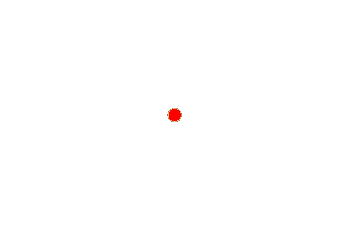

In [9]:
num_look = 150

sub_graph1 = train_g.subgraph(selected_nodes[:num_look])
sub_graph1.copy_from_parent()
sub_graph1.register_message_func(m_func)
sub_graph1.register_reduce_func(m_reduce_func)

sub_graph2 = test_g.subgraph(out_nodes)
sub_graph2.copy_from_parent()
sub_graph2.register_message_func(m_func)
sub_graph2.register_reduce_func(m_reduce_func)

knn.fit(model(sub_graph2, sub_graph2.ndata['features']).cpu().detach().numpy(), sub_graph2.ndata['t_labels'].cpu().detach().numpy())
sub_graph1.ndata['p_labels'] = th.LongTensor(knn.predict(model(sub_graph1, sub_graph1.ndata['features']).cpu().detach().numpy())).to(device)

feats = sub_graph1.ndata['features']
labs = sub_graph1.ndata['t_labels'] #true label
output = model(sub_graph1, feats)
print(output)
print(labs)

from collections import defaultdict
pos = defaultdict(list)
cos = []
cos2 = []

for n in range(num_look):
    pos[n] = (output[n][0].item(), output[n][1].item())
    cos.append(sub_graph1.ndata['p_labels'][n].item())
    cos2.append(sub_graph1.ndata['t_labels'][n].item())

nx.draw_networkx_nodes(sub_graph1.to_networkx(), pos, node_color=cos2, cmap=plt.get_cmap('rainbow'), vmin = float(ds_labels.min().item()), vmax = float(ds_labels.max().item()), node_size=150)
nx.draw(sub_graph1.to_networkx(), pos, node_color=cos, cmap=plt.get_cmap('rainbow'), vmin = float(ds_labels.min().item()), vmax = float(ds_labels.max().item()), node_size=100)